# INFO 103: Introduction to data science <br> Demo \#5: Pre-processing and storage <br> Author: JRW

## Mission
This workbook explores some of the challenges that arise once a source of data is identified. The song lyrics database is a nice example because our pipeline interacts with many aspects of the life cycle. Because we are allowed to download one copy of the entire website it is possible to have a complete collection, but this comes with a twist.

#### What's nice about a data API?
A data API, like those offered by with Twitter, Google, or Facebook, etc., provides convenient access for all kinds of data science projects. These systems of tools provide the opportunity to target specific subsets of data, without the burden of having to store everything and filter down first. However as we know, APIs often come with restrictions and paywalls.

#### Could songlyrics.com have an API?
Yes, of course, but their web server probably lacks the capacity to handle frequent and complicated requests. This limitation is actually reflected in their terms and conditions in the "one copy" policy. This "one copy" policy provides full access, similar to a database "dump", but also prevents users from developing their own API's. For example, if a user developed an API an d used it multiple times, they could easily violate the conditions by accessing the same piece of data twice. This is too bad! Unfortunately, then, we can't avoid having to collect the entire database before beginning with exploration, analysis and product design, etcetera. 

In [8]:
%matplotlib inline

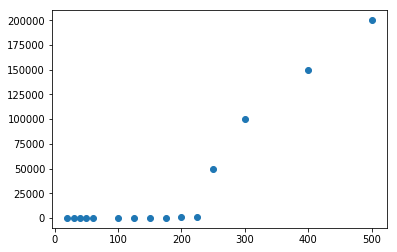

In [69]:
import matplotlib.pyplot as plt
import numpy as np
# w = 6
# h = 6
# d = 70
# plt.figure(figsize=(w, h), dpi=d)
x = [20, 30, 40, 50, 60, 100, 125, 150, 175, 200, 225, 250,300,400,500]
y = [30, 35, 40, 45, 50,60,70,200,400,800,1000,50000,100000,150000,200000]
plt.scatter(x, y,)
plt.show()

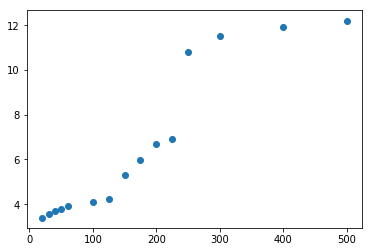

In [70]:
plt.scatter(x, np.log(y))
plt.show()

In [16]:
from bs4 import BeautifulSoup
import requests, re, string, json, os

#### Does our web-scraped data have good API-like functionality?
Suppose we want to only check out rock-genre song lyrics. Is our data storage system optimized for this task? No! Since web scraper covers the website alphabetically, we simplistically stored the data in large files by letter. This means the entire a-file would have to be read to get through to the last artist to find their rock-genre songs.

#### How can we build good API-like functionality?
At the very least, we should probably separate artists into individual files, but perhaps keep the alphabetic index by directories. Additionally, we should probably separate a table of metadata, giving us a roadmap for efficient slicing and dicing.

#### What sort of database are we building?
Note, that by separating out the artists and metadata, we are making it easier to:

1. insert new songs for individual artists, and 
2. make complex queries for specific data transformations.

So, for its flexibility and update speed, our target database format is probably best described as an OLTP system.

#### What about when we actually want to use the data for analysis?
Since this is an OLTP database, it will not actually be optimized for any specific analysis. So if we want to do something specific with the data, we will have to occasionally call our OLTP system to make specific transformations, which we will store elsewhere, thus creating an updating an OLAP database.

### Getting the data right, the first time
Rather than download all of the data as we had planned, it would probably be better to get the structure right upon access. So, here we're starting with our old web scraper, which stores songs by artist in large, alphabetic data files. Let's start out by highlighting where the changes will need to be.

In [4]:
#######################################################################
####### 0. Create a primary data directory. ###########################
#######################################################################
#######################################################################

#######################################################################
####### 1. Create reverse-lookup for songs by genre ###################
#######################################################################
#######################################################################

## go through all of the letters in the alphabet
for letter in string.ascii_lowercase:
    
    #######################################################################
    ####### 2. Create the letter-level directory ##########################
    #######################################################################
    #######################################################################
    
    #######################################################################
    ####### 3. Initialize a letter-level metadata file ####################
    ## create a data file for the current letter
    filename = "songlyrics-"+letter+".json"
    fh = open(filename,  "w")
    fh.close()
    #######################################################################
    #######################################################################
    
    ## open and parse the html for the current letter
    letterhtml = requests.get("http://www.songlyrics.com/"+letter+"/").text
    lettersoup = BeautifulSoup(letterhtml, 'lxml')

    ## collect the pages for this letter
    pages = ["/"+letter+"/"]
    for letterlink in lettersoup.find_all('a'):
        ## filter links for letter pages
        if letterlink.get("href") is not None and re.search("^Page \d+$", letterlink.get("title", "NOTITLE")):            
            pages.append(letterlink['href'])

    ## go through the letter pages
    for page in pages:        
        ## open and parse the html for the current page of this letter
        pagehtml = requests.get("http://www.songlyrics.com"+page).text
        pagesoup = BeautifulSoup(pagehtml, 'lxml')

        ## go through the artists in the page
        for pagelink in pagesoup.find_all('a'):
            ## filter links for artist pages
            if re.search("^http://.*?-lyrics/$",pagelink.get("href", "NOLINK")):

                #######################################################################                
                ####### 4. remove old data structure and hold on to the artist's name #
                ## set up data and store artist-level information
                data = {
                    "Artist": pagelink.text,
                    "url": pagelink['href'],
                    "Songs": {}
                }
                #######################################################################
                #######################################################################

                #######################################################################
                ####### 5. Output artist info to letter-level metadata file ###########
                #######################################################################
                #######################################################################

                #######################################################################
                ####### 6. Create artist-level directory. #############################
                #######################################################################
                #######################################################################
                
                #######################################################################
                ####### 7. Create an artist-level metadata file #######################
                #######################################################################
                #######################################################################      
                
                ## open and parse the html for the current artist on this page
                artisthtml = requests.get(data["url"]).text
                artistsoup = BeautifulSoup(artisthtml, 'lxml')                        

                ## go through the songs of this artist
                for songlink in artistsoup.find_all('a'):

                    ## filter links for song pages
                    if songlink.get("itemprop", "NOITEMPROP") == "url" and songlink.get("title") is not None:
                                                
                        #######################################################################
                        ############ 8. Hold song title; store info as artist-level metadata ##
                        ## store initial song-level information
                        title = songlink.text
                        data["Songs"][title] = {"Title": title}
                        data["Songs"][title]["url"] = songlink['href']
                        #######################################################################
                        #######################################################################                        

                        ## open and parse the html for the current song by this artist
                        songhtml = requests.get(data["Songs"][title]["url"]).text
                        songsoup = BeautifulSoup(songhtml, 'lxml')

                        ## go through paragraphs to find song attributes
                        for par in songsoup.find_all("p"):
                            if re.search(": ", par.text):
                                pieces = re.split(": ", par.text)
                                key = pieces[0]
                                value = ": ".join(pieces[1:len(pieces)])

                                #######################################################################                                
                                ############ 9. add song attributes to artist-level metadata ##########
                                data["Songs"][title][key] = value    
                                #######################################################################
                                #######################################################################                        

                                #######################################################################                                
                                ############ 10. add song attributes to reverse song lookup ###########
                                #######################################################################
                                #######################################################################                                

                        #######################################################################                                
                        ############ 11. output song metadata to artist-level metadata file ###
                        #######################################################################
                        #######################################################################                                
                                
                        ## go through divs to find the one with the song lyrics
                        for div in songsoup.find('body').find_all('div'):
                            if div.get("id","NOCLASS") == "songLyricsDiv-outer":
                                
                                #######################################################################                                
                                ############ 12. output song lyrics as text in artist-level directory #                                
                                data["Songs"][title]["Lyrics"]=div.text
                                #######################################################################
                                #######################################################################
                        
                        break
                        
                #######################################################################
                #### 13. remove old data write out ####################################
                
                ## write out the data for this artist, appending to the end of this letter's file
                with open(filename, "a") as fh:
                    fh.writelines(json.dumps(data)+"\n")
                    
                #######################################################################
                #######################################################################
                
                break
        break
        
    break

#######################################################################
####### 14. Output reverse-lookup for songs by attributes #############
#######################################################################
#######################################################################

### Making the changes
Note that by making a reverse lookup metadata file for artists by associated song attributes, we are actually beginning to look forward towards creating an OLAP database. Why? This is because we are:

1. Denormalizing data, i.e., duplicating information,
2. making it easy to specific transformations interesting for analysis. 

Note that throughout this code that we have had to create unique keys for artists and song titles, since using their actual texts as keys is dangerous, on account of difficult characters! Anyway, here's the modified scraper:

In [65]:
#######################################################################
####### 0. Create a primary data directory. ###########################
os.system("mkdir ./data/")
#######################################################################
#######################################################################

#######################################################################
####### 1. Create objects for reverse-lookup of songs by genre ########
songsByAttribute = {}
attributeIDs = {}
attributes = {}
attributeNumbers = {}
#######################################################################
#######################################################################

## go through all of the letters in the alphabet
for letter in string.ascii_lowercase:

    numartists = 0
    
    #######################################################################
    ####### 2. Create the letter-level directory ##########################
    os.system("mkdir ./data/"+letter+"/")
    #######################################################################
    #######################################################################    
    
    #######################################################################
    ####### 3. Initialize a letter-level metadata file ####################
    lettermetafile = "./data/"+letter+"/lettermeta.json"
    fh = open(lettermetafile,  "w")
    fh.close()    
    #######################################################################
    #######################################################################
    
    ## open and parse the html for the current letter
    letterhtml = requests.get("http://www.songlyrics.com/"+letter+"/").text
    lettersoup = BeautifulSoup(letterhtml, 'lxml')

    ## collect the pages for this letter
    pages = ["/"+letter+"/"]
    for letterlink in lettersoup.find_all('a'):
        ## filter links for letter pages
        if letterlink.get("href") is not None and re.search("^Page \d+$", letterlink.get("title", "NOTITLE")):            
            pages.append(letterlink['href'])

    ## go through the letter pages
    for page in pages:        
        ## open and parse the html for the current page of this letter
        pagehtml = requests.get("http://www.songlyrics.com"+page).text
        pagesoup = BeautifulSoup(pagehtml, 'lxml')

        ## go through the artists in the page
        for pagelink in pagesoup.find_all('a'):
            ## filter links for artist pages
            if re.search("^http://.*?-lyrics/$",pagelink.get("href", "NOLINK")):
                
                #######################################################################                
                ####### 4. remove old data structure and hold on to the artist's data #
                ## keep track of number of artists, songs, and create an ID
                numartists += 1
                artistID = letter+"-"+str(numartists)
                numsongs = 0
                
                artist = pagelink.text
                artisturl = pagelink['href']
                
#                 ## set up data and store artist-level information
#                 data = {
#                     "Artist": pagelink.text,
#                     "url": pagelink['href'],
#                     "Songs": {}
#                 }                
                #######################################################################
                #######################################################################

                #######################################################################                
                ####### 5. Output artist info to letter-level metadata file ###########
                with open(lettermetafile,  "a") as f:
#                     print(artistID.encode("utf-8"),artist.encode("utf-8"),artisturl.encode("utf-8"))
                    f.writelines(artistID+'\t'+str(artist)+'\t'+str(artisturl)+'\n')                    
                #######################################################################
                #######################################################################                    
                    
                #######################################################################
                ####### 6. Create artist-level directory. #############################
                os.system("mkdir ./data/"+letter+"/"+artistID+"/")
                #######################################################################
                #######################################################################
                
                #######################################################################
                ####### 7. Create an artist-level metadata file #######################
                artistmetafile = "./data/"+letter+"/"+artistID+"/artistmeta.json"
                fh = open(artistmetafile,  "w")
                fh.close()               
                #######################################################################
                #######################################################################                
                                
                ## open and parse the html for the current artist on this page
                ## note we now use the artist's url!
                artisthtml = requests.get(artisturl).text
                artistsoup = BeautifulSoup(artisthtml, 'lxml')                        

                ## go through the songs of this artist
                for songlink in artistsoup.find_all('a'):

                    ## filter links for song pages
                    if songlink.get("itemprop", "NOITEMPROP") == "url" and songlink.get("title") is not None:                        

                        #######################################################################
                        ############ 8. Hold song title; store info as artist-level metadata ##
                        ## keep track of number of songs and create and ID
                        numsongs += 1
                        titleID = artistID+"-"+str(numsongs)
                        
                        ## hold on to the song's title
                        title = songlink.text
                        
#                         data["Songs"][title] = {"Title": title}
#                         data["Songs"][title]["url"] = songlink['href']

                        data = {
                            "ID": titleID,
                            "title": title,
                            "url": songlink['href']
                        }
                        #######################################################################
                        #######################################################################

                        ## open and parse the html for the current song by this artist
                        ## note the data format has changed to get the song's url!
                        songhtml = requests.get(data["url"]).text
                        songsoup = BeautifulSoup(songhtml, 'lxml')

                        ## go through paragraphs and get song attributes
                        for par in songsoup.find_all("p"):
                            if re.search(": ", par.text):
                                pieces = re.split(": ", par.text)
                                key = pieces[0]
                                value = ": ".join(pieces[1:len(pieces)])

                                #######################################################################                                
                                ############ 9. add song attributes to artist-level metadata ##########
                                if key != "Note":
                                    data[key] = value
                                #######################################################################
                                #######################################################################
                                
                                #######################################################################                                
                                ############ 10. add song attributes to reverse song lookup ###########
                                if key != "Note":
                                    attributeNumbers.setdefault(key, 1)
                                    attributeIDs.setdefault(key, {})
                                    attributes.setdefault(key, {})
                                    if not attributeIDs[key].get(value, False):
                                        attributeID = key+"-"+str(attributeNumbers[key])
                                        attributes[key][attributeID] = value
                                        attributeIDs[key][value] = attributeID
                                        attributeNumbers[key] += 1
                                    else:
                                        attributeID = attributeIDs[key][value]                                        
                                    
                                    songsByAttribute.setdefault(key, {})
                                    songsByAttribute[key].setdefault(attributeID, {})
                                    songsByAttribute[key][attributeID].setdefault(artistID, [])
                                    songsByAttribute[key][attributeID][artistID].append(titleID)
                                #######################################################################
                                #######################################################################

                        #######################################################################                                
                        ############ 11. output song metadata to artist-level metadata file ###
                        with open(artistmetafile,  "a") as f:
                            f.writelines(json.dumps(data)+"\n")
                        #######################################################################
                        #######################################################################                            
                                
                        ## go through divs to find the one with the song lyrics
                        for div in songsoup.find('body').find_all('div'):
                            if div.get("id","NOCLASS") == "songLyricsDiv-outer":

                                #######################################################################                                
                                ############ 12. output song lyrics as text in artist-level directory #
                                with open("./data/"+letter+"/"+artistID+"/"+titleID+".txt", "w") as f:
                                    f.writelines(str(div.text)+"\n")
                                
#                                 data["Songs"][title]["Lyrics"]=div.text
                                #######################################################################
                                #######################################################################

                                break
            
                    ## now, only break after 10 songs by an artist
                    if numsongs >= 10:
                        break
                        
                #######################################################################
                #### 13. remove old data write out ####################################
#                 ## write out the data for this artist, appending to the end of this letter's file
#                 with open(filename, "a") as fh:
#                     fh.writelines(json.dumps(data)+"\n")
                #######################################################################
                #######################################################################
                
            ## now, only break if this is the tenth artist of this letter!
            if numartists >= 10:
                break
        
        ## this stops us after one page of each letter
        break
        
    ## this stops us after one letter in the alphabet
#     break

#######################################################################
####### 14. Output reverse-lookup for songs by genre ##################
os.system("mkdir ./data/Genre/")
fh = open("./data/Genre/attributeIDs.txt", "w")
for attributeID in songsByAttribute["Genre"]:
    fh.writelines(attributeID +"\t"+str(attributes["Genre"][attributeID])+"\n")
    with open("./data/Genre/"+attributeID+".json", "w") as f:
        f.writelines(json.dumps(songsByAttribute["Genre"][attributeID])+"\n")
fh.close()
#######################################################################
#######################################################################

#### Accessing our database
As mentioned, the goal here is to replicate an API-like service for a local database. Let's work on our goal of being able to access data by genre. To do this, we'll make a function that reads the appropriate reverse-lookup file and finds all songs titles/artists with the desired genre.

In [63]:
genres = {}
with open("./data/Genre/attributeIDs.txt", "r") as f:
    for line in f:
        line = line.strip()
        ID, genre = re.split("\t", line)
        
        genres[genre] = ID


def genreSongs(genre):
    with open("./data/Genre/"+genres[genre]+".json") as f:
        genredata = json.loads(f.read())
    data = []
    for artistID in genredata:
        letter = artistID[0]
        songs = genredata[artistID]
        with open("./data/"+letter+"/"+artistID+"/artistmeta.json") as f:
            for line in f:
                line = line.strip()
                songmeta = json.loads(line)
                if songmeta["ID"] in songs:
                    data.append((songmeta["Artist"], songmeta["title"]))

    return data

In [64]:
for artist, song in genreSongs("Rock"):
    print("Artist: "+artist)
    print("Song: "+song)
    print    

Artist: A
Song: Sing-A-Long
Artist: X
Song: 4th of July


### Where to go from here?
This has really just been the tip of the iceberg! To create a truly functional API-like utility we will need to make a whole suite of functions that can slice and dice our data. There are many more attributes besides Genre, and we may just want some basic stuff, too, that can look up to find all of the songs by an artist or within an album.